# **Adaboost Algorithm from scratch**

Importing libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('/content/Prostate_Cancer.csv')
df.head()

,id,diagnosis_result,radius,texture,perimeter,area,smoothness,compactness,symmetry,fractal_dimension
0,1,M,23,12,151,954,0.143,0.278,0.242,0.079
1,2,B,9,13,133,1326,0.143,0.079,0.181,0.057
2,3,M,21,27,130,1203,0.125,0.160,0.207,0.060
3,4,M,14,16,78,386,0.070,0.284,0.260,0.097
4,5,M,9,19,135,1297,0.141,0.133,0.181,0.059


data preparation

In [3]:
labels = df['diagnosis_result']
features = df.drop(columns=['id','diagnosis_result'])


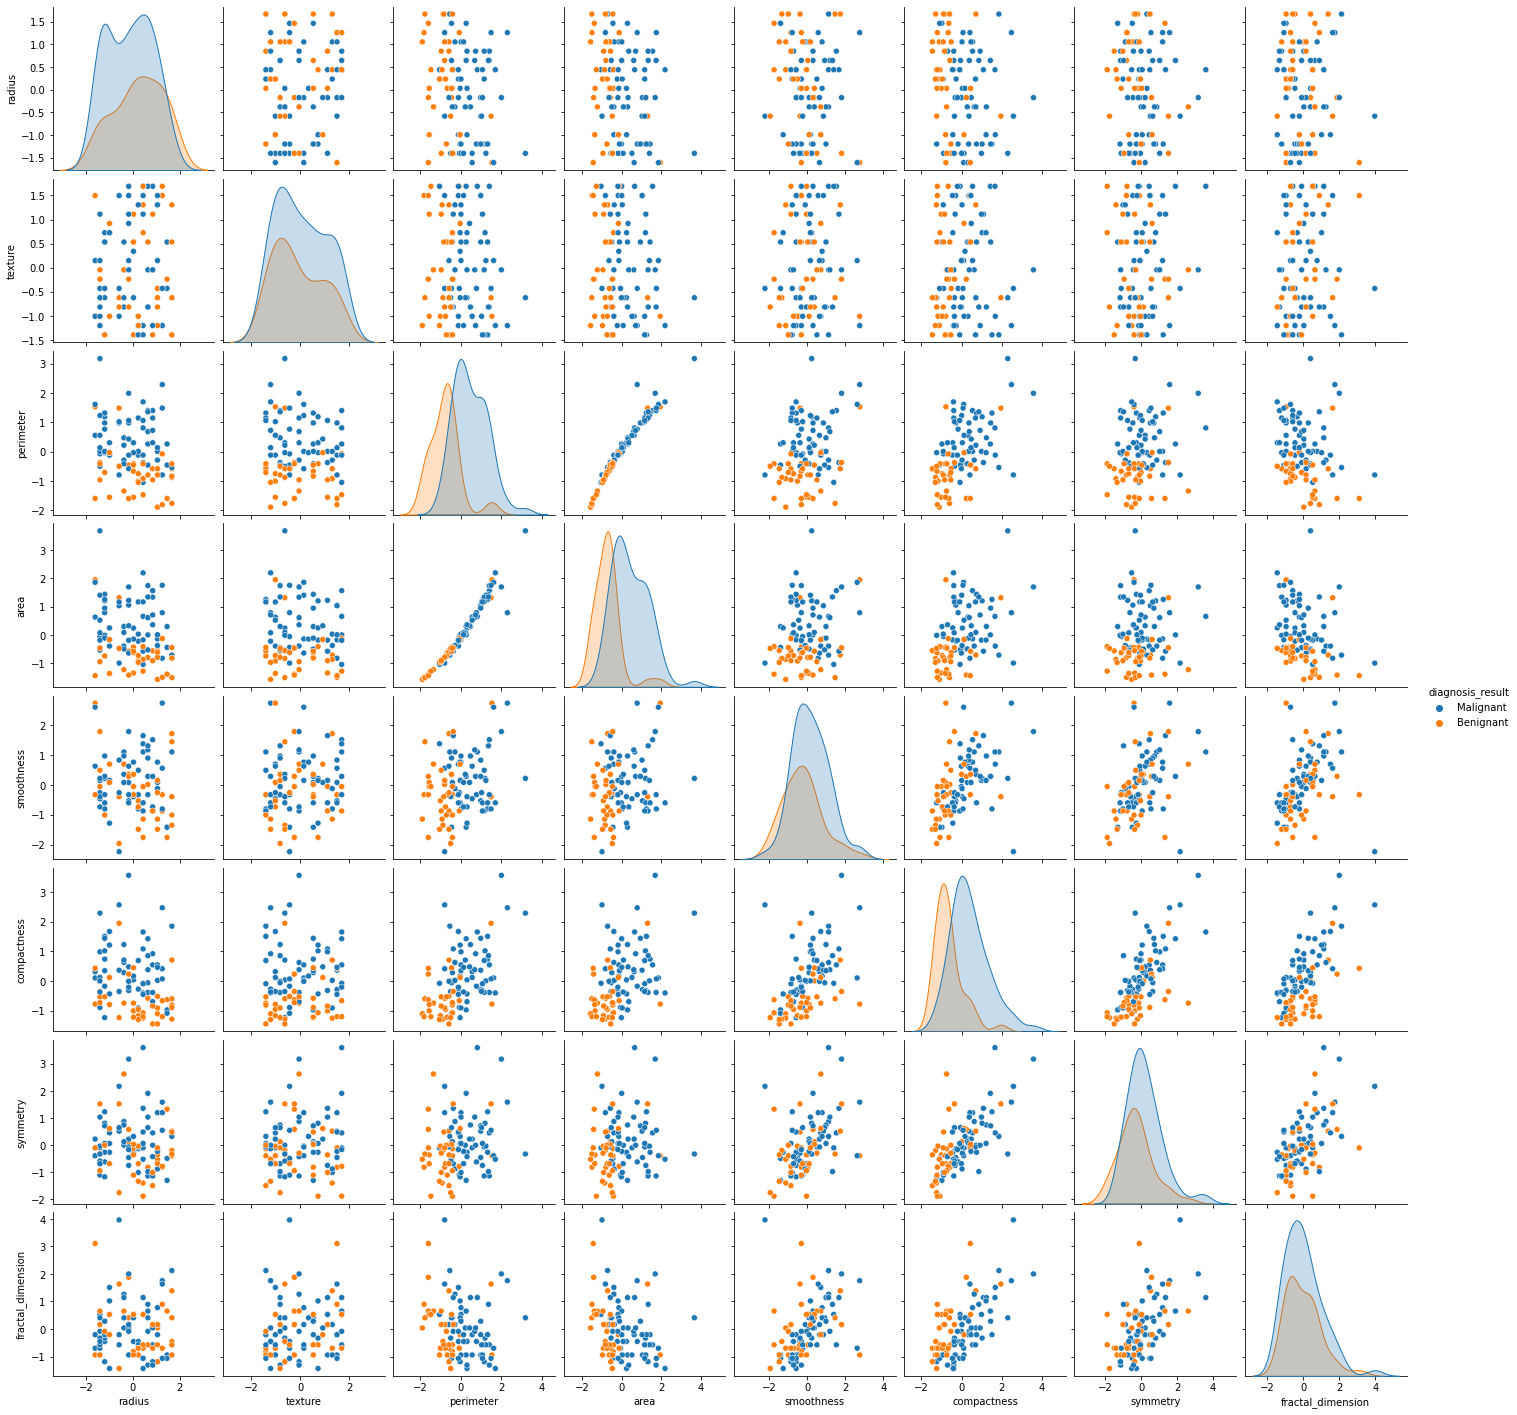

In [4]:
features = (features - features.mean())/features.std()
features.head()

categories_to_idx = {'M' : 1, 'B' : -1}
idx_to_categories = { 1 : 'Malignant', -1 : 'Benignant'}

labels = pd.DataFrame(labels.replace(categories_to_idx))
sns.pairplot(pd.concat([pd.DataFrame(labels.replace(idx_to_categories)), features], axis=1), hue="diagnosis_result")

In [5]:
X_train, X_test, y_train, y_test = train_test_split(features.values, labels.values.reshape(-1), test_size=0.33, random_state=42)

**Implementing adaboost**

In [6]:
class Adaboost():
  
    class Decision():
        def __init__(self):
            self.polarity = 1
            self.feature_idx = None
            self.threshold = None
            self.alpha = None

        def predict(self, X):
            n_samples = X.shape[0]
            X_column = X[:, self.feature_idx]
            predictions = np.ones(n_samples)
            if self.polarity == 1:
                predictions[X_column < self.threshold] = -1
            else:
                predictions[X_column > self.threshold] = -1

            return predictions

    def __init__(self, n_clf=5):
        self.n_clf = n_clf
        
    def predict(self, X):
        clf_preds = [clf.alpha * clf.predict(X) for clf in self.clfs]
        y_pred = np.sum(clf_preds, axis=0)
        y_pred = np.sign(y_pred)

        return y_pred

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Initialize weights to 1/N
        w = np.full(n_samples, (1 / n_samples))

        self.clfs = []
        # Iterate through classifiers
        for _ in range(self.n_clf):
            clf = self.Decision()

            min_error = float('inf')
            # greedy search to find best threshold and feature
            for feature_i in range(n_features):
                X_column = X[:, feature_i]
                thresholds = np.unique(X_column)

                for threshold in thresholds:
                    # predict with polarity 1
                    p = 1
                    predictions = np.ones(n_samples)
                    predictions[X_column < threshold] = -1

                    # Error = sum of weights of misclassified samples
                    misclassified = w[y != predictions]
                    error = sum(misclassified)

                    if error > 0.5:
                        error = 1 - error
                        p = -1

                    # store the best configuration
                    if error < min_error:
                        clf.polarity = p
                        clf.threshold = threshold
                        clf.feature_idx = feature_i
                        min_error = error

            # calculate alpha
            EPS = 1e-10
            clf.alpha = 0.5 * np.log((1.0 - min_error + EPS) / (min_error + EPS))

            # calculate predictions and update weights
            predictions = clf.predict(X)

            w *= np.exp(-clf.alpha * y * predictions)
            # Normalize to one
            w /= np.sum(w)

            # Save classifier
            self.clfs.append(clf)
adaboost = Adaboost()
adaboost.fit(X_train, y_train)

**Evaluating results**

In [7]:
def get_accuracy(X, y):
    predictions = adaboost.predict(X)
    accuracy = len(np.where(predictions == y)[0]) / len(y)
    return accuracy


In [8]:
accuracy = get_accuracy(X_train, y_train)
print("Train Accuracy: {0:1.4f}".format(accuracy))



Train Accuracy: 0.9403


In [9]:
accuracy = get_accuracy(X_test, y_test)
print("Test Accuracy: {0:1.4f}".format(accuracy))

Test Accuracy: 0.7576
